In [1]:
import os, sys, pickle
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'

In [2]:
ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-19_02-13-22_11754/logs.
Waiting for redis server at 127.0.0.1:33159 to respond...
Waiting for redis server at 127.0.0.1:38948 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_addresses': ['/tmp/ray/session_2019-04-19_02-13-22_11754/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-19_02-13-22_11754/sockets/raylet'],
 'redis_address': '10.138.0.2:33159',
 'webui_url': ''}

In [3]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

create_env, env_name = make_create_env(params=flow_params, version=0)

In [4]:
# Register as rllib env
register_env(env_name, create_env)

In [5]:
checkpoint = '475'

In [6]:
config_path = '/headless/rl_project/ray_results/multi_merge/PPO_MultiWaveAttenuationMergePOEnv-v0_0_2019-04-18_22-06-061w6z291m/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/multi_merge/PPO_MultiWaveAttenuationMergePOEnv-v0_0_2019-04-18_22-06-061w6z291m/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

In [7]:
with open(config_path, mode='rb') as f:
    config = pickle.load(f)

In [8]:
agent = PPOAgent(config=config, env=env_name)

Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-19_02-13-348chxbs3b -> None
 Starting SUMO on port 52337
2019-04-19 02:13:36,001	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 52337
2019-04-19 02:13:40,135	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
agent.restore(checkpoint_path)

In [10]:
# env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
env = create_env()

 Starting SUMO on port 48595


In [11]:
for i in range(5):
    vel = []
    state = env.reset()
    for _ in range(env.env_params.horizon):
        vel.append(np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids())))
        ids = env.k.vehicle.get_controlled_ids()
        actions = {}
        for id_ in ids:
            action = agent.compute_action(state[id_])
            actions.update({id_: action})
        state, r, _, _ = env.step(actions)
    print(np.mean(vel))
    if i == 0:
        vels = np.array(vel)
    else:
        vels = np.vstack((vels, np.array(vel)))

 Starting SUMO on port 48595
 Starting SUMO on port 48595


6.819077881679102


 Starting SUMO on port 48595


6.528329248461748


 Starting SUMO on port 48595


6.7637117893049705


 Starting SUMO on port 48595


6.963061266529627
6.372927303504065


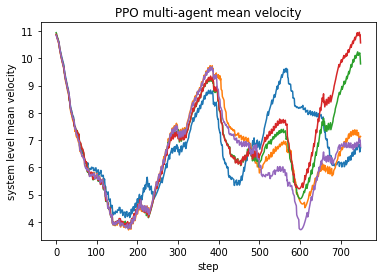

In [12]:
title = 'PPO multi-agent mean velocity'
savepath = '../result/MultiAgent' + title.replace(' ', '_') + '.png'

fig = plt.figure()
fig.clf()
plt.title(title)
plt.ylabel('system level mean velocity')
plt.xlabel('step')
for vel in vels:
    plt.plot(vel)
plt.savefig(savepath)